# Data processing

## Data to process

From GIS:
- DEM: Elevation map
- Curvature
- Aspect
- Slope angle  
- Stream density
- Distances from the stream network
- Topographic wetness index (TWI)

From geology data:
- Lithology map

From flood inventory:
- flood map: coordinates -> map

### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba

from scipy import ndimage

import geopandas as gpd

In [3]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 11.1 MB/s eta 0:00:00


In [4]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

### Data path

In [5]:
input_path = "/content/drive/MyDrive/PROJECT ML/InputsforDataprocess"
output_path = "/content/drive/MyDrive/PROJECT ML/ProcessedData"

In [6]:
def save_array_as_npy(array, name):
    output_fn = os.path.join(output_path, f"{name}.npy")

    print(f"shape of {name}", array.shape)
    print("saved to", output_fn)

    np.save(output_fn, array)

def load_array_from_npy(name):
    return np.load(os.path.join(output_path, f"{name}.npy"))

## DEM: Elevation map

In [7]:
# Merging two downloaded DEMs

from rasterio.merge import merge
from rasterio.enums import Resampling

def merge_dem(input_dem1_path, input_dem2_path, output_merged_dem_path):
    # Open the input DEM files
    with rasterio.open(input_dem1_path) as src1, rasterio.open(input_dem2_path) as src2:
        # Merge the DEMs
        datasets = [src1, src2]
        merged_dem, out_transform = merge(datasets, resampling=Resampling.bilinear)

        # Update metadata for the merged raster
        out_meta = src1.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": merged_dem.shape[1],
            "width": merged_dem.shape[2],
            "transform": out_transform
        })

        # Save the merged DEM to a new GeoTIFF file
        with rasterio.open(output_merged_dem_path, "w", **out_meta) as dest:
            dest.write(merged_dem)

# Example usage
input_dem1_path = os.path.join(input_path, "USGS_1_n31w090_20231101.tif")
input_dem2_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")
output_merged_dem_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")

merge_dem(input_dem1_path, input_dem2_path, output_merged_dem_path)


In [8]:
# clipping two merged DEM by the shapefile of the counties

def clip_dem(input_dem_path, output_clipped_dem_path, shapefile_path):
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile_path)

    # Get the geometry from the shapefile
    clip_geometry = gdf.geometry.unary_union

    # Open the input DEM file
    with rasterio.open(input_dem_path) as src:
        # Clip the raster using the shapefile geometry
        shape_mask = np.ones(src.shape)
        out_image, out_transform = mask(src, [mapping(clip_geometry)], crop=True)

        # Update metadata for the clipped raster
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Save the clipped DEM to a new GeoTIFF file
        with rasterio.open(output_clipped_dem_path, "w", **out_meta) as dest:
            dest.write(out_image)

    return out_image


# Example usage
input_dem_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")
output_clipped_dem_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")
shape_fn = "united_states_louisiana_administrative_boundaries_level6_counties_polygon.shx"
shapefile_path = os.path.join(input_path, shape_fn)

out_image = clip_dem(input_dem_path, output_clipped_dem_path, shapefile_path)


In [9]:
gdf = gpd.read_file(shapefile_path)

In [10]:
gdf

,admin_leve,boundary,name,place,population,z_order,way_area,geometry
0,6,administrative,Tangipahoa Parish,None,128755,0,2.906170e+09,"POLYGON ((-90.56743 30.63135, -90.56720 30.650..."
1,6,administrative,Washington Parish,None,46371,0,2.387990e+09,"POLYGON ((-90.34736 31.00051, -90.34601 31.000..."
2,6,administrative,St. Tammany Parish,None,250088,0,3.926690e+09,"POLYGON ((-90.25668 30.70235, -90.25557 30.712..."


In [14]:
with rasterio.open(input_dem_path) as src:
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -999999.0, 'width': 3862, 'height': 3106, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.000277777777786999, 0.0, -90.56750000003481,
       0.0, -0.000277777777786999, 31.001666666983965)}


In [ ]:
elevation = out_image[0]

# compute the region to be masked
shape_mask = (elevation < -1e4)

In [ ]:
save_array_as_npy(elevation, "elevation")

shape of elevation (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/elevation.npy


In [ ]:
save_array_as_npy(shape_mask, "shape_mask")

shape of shape_mask (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/shape_mask.npy


## Curvature data

In [ ]:
deg_to_m = 111139

In [ ]:
# Deriving Curvature data from DEM

def calculate_curvature(input_dem_path, output_curvature_path):
    # Open the DEM file
    with rasterio.open(input_dem_path) as src:
        # Read the DEM data as a NumPy array
        dem_data = src.read(1)

        # Compute the resolution
        res = (src.res[0] * deg_to_m, src.res[1] * deg_to_m)

        # Calculate the gradient (slope) using NumPy's gradient function
        slope_x, slope_y = np.gradient(dem_data, *res)

        # Calculate the second derivatives
        slope_xx, slope_xy = np.gradient(slope_x, *res)
        slope_yx, slope_yy = np.gradient(slope_y, *res)

        # Calculate total curvature
        eps = 1e-5  #1
        curvature = (slope_xx * slope_yy - slope_xy * slope_yx) / \
                        ((eps + slope_x**2 + slope_y**2)**(1.5))

        # Save the curvature data to a new GeoTIFF file
        with rasterio.open(output_curvature_path, "w", driver="GTiff",
                           height=curvature.shape[0], width=curvature.shape[1],
                           count=1, dtype=str(curvature.dtype),
                           crs=src.crs, transform=src.transform) as dest:
            dest.write(curvature, 1)

    return curvature

# Example usage
input_dem_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")
output_curvature_path = os.path.join(input_path, "CURVATURE")

curvature = calculate_curvature(input_dem_path, output_curvature_path)

In [ ]:
bin_curvature = -1 * (curvature < -1e-3) + 1 * (curvature > 1e-3)

In [ ]:
save_array_as_npy(curvature, "curvature")

shape of curvature (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/curvature.npy


In [ ]:
save_array_as_npy(bin_curvature, "bin_curvature")

shape of bin_curvature (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/bin_curvature.npy


## Aspect data

In [ ]:
# driving aspect data from DEM

def calculate_aspect(input_dem_path, output_aspect_path):
    # Open the DEM file
    with rasterio.open(input_dem_path) as src:
        # Read the DEM data as a NumPy array
        dem_data = src.read(1)

        # Compute the resolution
        res = (src.res[0] * deg_to_m, src.res[1] * deg_to_m)

        # Calculate the gradient (slope) using NumPy's gradient function
        slope_x, slope_y = np.gradient(dem_data, *res)

        # Calculate the aspect in radians
        aspect_rad = np.arctan2(-slope_y, -slope_x)

        # Convert radians to degrees and adjust for 0 to 360 degrees
        aspect_deg = np.degrees(aspect_rad)
        aspect_deg = aspect_deg % 360

        # Save the aspect data to a new GeoTIFF file
        with rasterio.open(output_aspect_path, "w", driver="GTiff",
                           height=aspect_deg.shape[0], width=aspect_deg.shape[1],
                           count=1, dtype=str(aspect_deg.dtype),
                           crs=src.crs, transform=src.transform) as dest:
            dest.write(aspect_deg, 1)

    # discard aspect data where surface is flat
    slope_norm = np.sqrt(slope_x**2 + slope_y**2)
    flat_surface = slope_norm < 0.0005

    return flat_surface, aspect_deg

# Example usage
input_dem_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")
output_aspect_path = os.path.join(input_path, "Aspect")

aspect_flat, aspect_deg = calculate_aspect(input_dem_path, output_aspect_path)

In [ ]:
bin_aspect = (((aspect_deg+22.5)%360) // 45).astype(int)
bin_aspect[bin_aspect == 8] = 0

In [ ]:
save_array_as_npy(aspect_deg, "aspect_deg")

shape of aspect_deg (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/aspect_deg.npy


In [ ]:
save_array_as_npy(bin_aspect, "bin_aspect")

shape of bin_aspect (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/bin_aspect.npy


In [ ]:
save_array_as_npy(aspect_flat, "aspect_flat")

shape of aspect_flat (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/aspect_flat.npy


## Slope angle data

In [ ]:
def calculate_slope_angle(input_dem_path, output_slope_angle_path):
    # Open the DEM file
    with rasterio.open(input_dem_path) as src:
        # Read the DEM data as a NumPy array
        dem_data = src.read(1)

        # Compute the resolution
        res = (src.res[0] * deg_to_m, src.res[1] * deg_to_m)

        # Calculate the gradient (slope) using NumPy's gradient function
        slope_x, slope_y = np.gradient(dem_data, *res)

        # Calculate the slope angle in radians
        slope_angle_rad = np.arctan(np.sqrt(slope_x**2 + slope_y**2))

        # Convert radians to degrees
        slope_angle_deg = np.degrees(slope_angle_rad)

        # Save the slope angle data to a new GeoTIFF file
        with rasterio.open(output_slope_angle_path, "w", driver="GTiff",
                           height=slope_angle_deg.shape[0], width=slope_angle_deg.shape[1],
                           count=1, dtype=str(slope_angle_deg.dtype),
                           crs=src.crs, transform=src.transform) as dest:
            dest.write(slope_angle_deg, 1)

    return slope_angle_deg

# Example usage
input_dem_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")
output_slope_angle_path = os.path.join(input_path, "Slope")

slope_angle_deg = calculate_slope_angle(input_dem_path, output_slope_angle_path)

In [ ]:
save_array_as_npy(slope_angle_deg, "slope_angle")

shape of slope_angle (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/slope_angle.npy


## Stream density

Importing Stream density TIF file directly from ArcGIS.

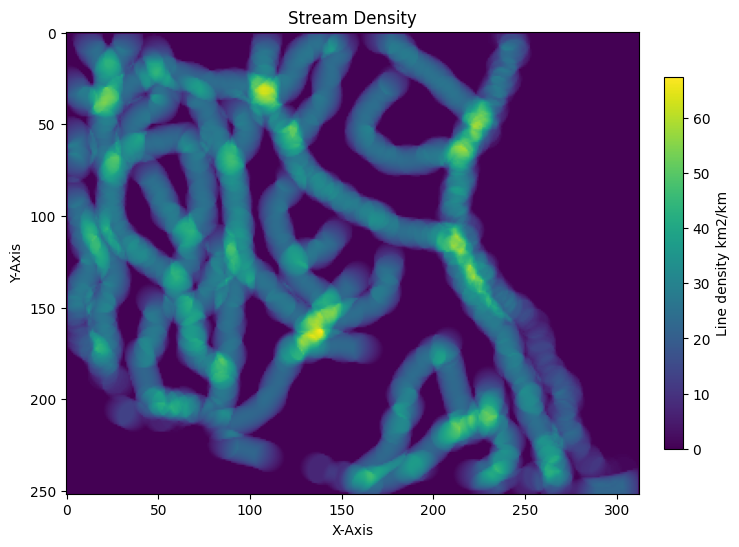

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Path
tif_path = os.path.join(input_path, "StreamDensity.tif")

# Open
with rasterio.open(tif_path) as src:
    # Read
    raster_data = src.read()

    stream_density = raster_data[0]

# Display
fig, ax = plt.subplots(figsize=(8, 6))

img = ax.imshow(stream_density, cmap='viridis')

cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Line density km2/km')

plt.title('Stream Density')
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.show()

In [ ]:
shape_mask.shape

(3106, 3862)

In [ ]:
stream_density.shape

(252, 313)

In [ ]:
print(3106/3862, 252/313)

0.8042465044018643 0.805111821086262


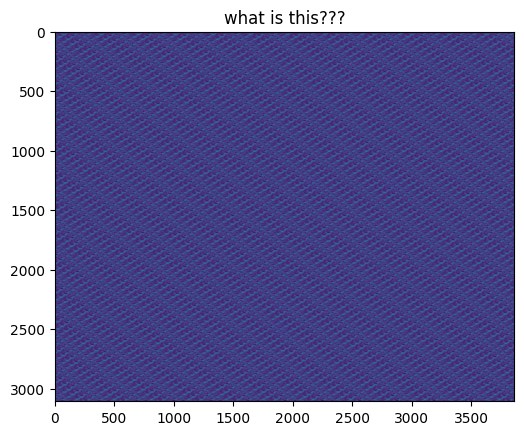

In [ ]:
# WRONG METHOD TO RESIZE AN IMAGE
# DO NOT REPRODUCE

np_reduced_stream_density = np.resize(stream_density, shape_mask.shape)

plt.imshow(np_reduced_stream_density)
plt.title('what is this???')
plt.show()

(3106, 3862)


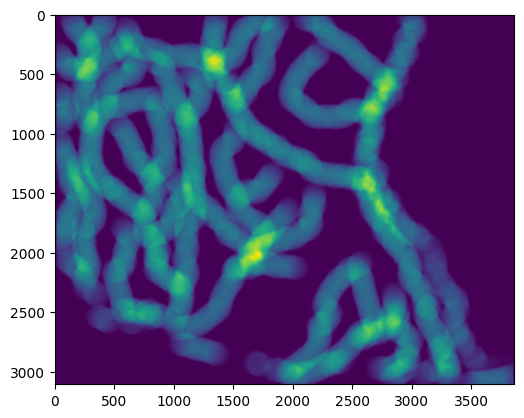

In [ ]:
import cv2

resized_stream_density = cv2.resize(stream_density,
                            dsize=shape_mask.shape[::-1],
                            #interpolation=cv2.INTER_CUBIC
                            )

print(resized_stream_density.shape)

plt.imshow(resized_stream_density)
plt.show()

In [ ]:
save_array_as_npy(resized_stream_density, "stream_density")

shape of stream_density (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/stream_density.npy


## Distance from streams

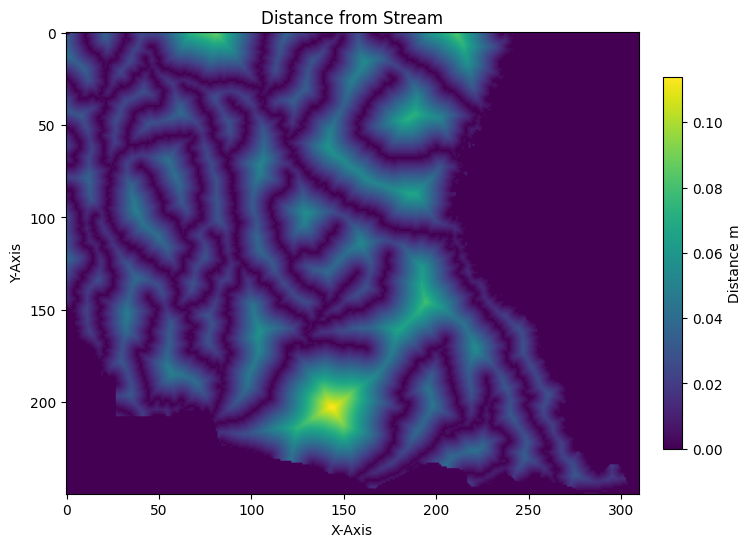

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Path
tif_path = os.path.join(input_path, "Distancetostream.tif")

# Open
with rasterio.open(tif_path) as src:
    # Read
    raster_data = src.read()

    distance_to_stream = raster_data[0]

    # Display
    fig, ax = plt.subplots(figsize=(8, 6))

    img = ax.imshow(distance_to_stream, cmap='viridis')

    cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Distance m')

    plt.title('Distance from Stream')
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.show()

In [ ]:
distance_to_stream.shape

(250, 310)

(3106, 3862)


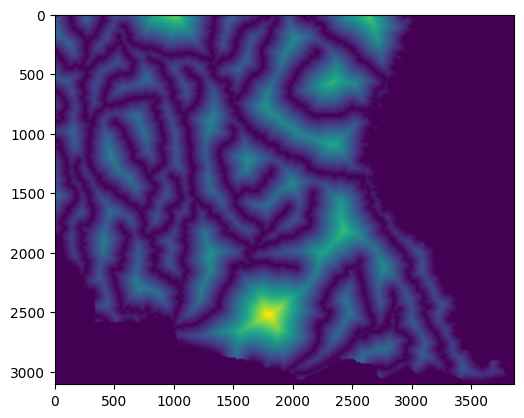

In [ ]:
resized_distance_to_stream = cv2.resize(distance_to_stream,
                            dsize=shape_mask.shape[::-1],
                            #interpolation=cv2.INTER_CUBIC
                            )

print(resized_distance_to_stream.shape)

plt.imshow(resized_distance_to_stream)
plt.show()

In [ ]:
save_array_as_npy(resized_distance_to_stream, "distance_to_stream")

shape of distance_to_stream (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/distance_to_stream.npy


## Topographic wetness index (TWI)

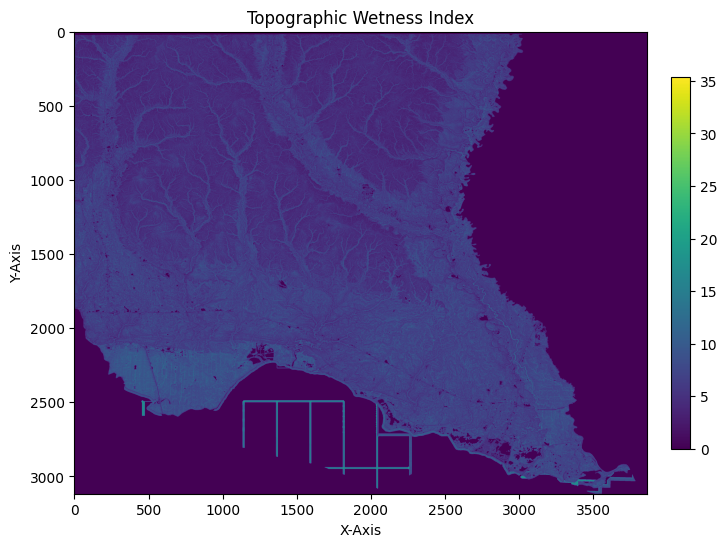

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Path
tif_path = os.path.join(input_path, "TWI.tif")

# Open
with rasterio.open(tif_path) as src:
    # Read
    raster_data = src.read()

    twi_map = raster_data[0]

    # Display
    fig, ax = plt.subplots(figsize=(8, 6))

    img = ax.imshow(twi_map, cmap='viridis')

    cbar = plt.colorbar(img, ax=ax, fraction=0.03, pad=0.04)


    plt.title('Topographic Wetness Index')
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.show()

(3106, 3862)


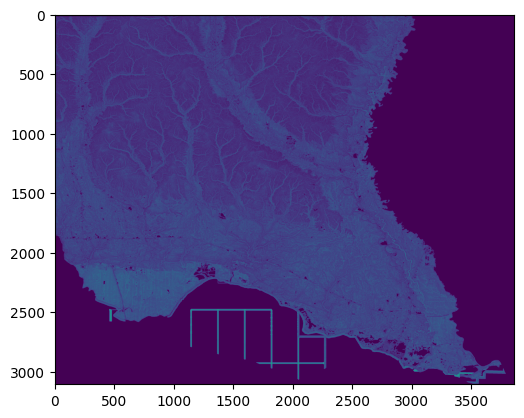

In [ ]:
resized_twi_map = cv2.resize(twi_map,
                            dsize=shape_mask.shape[::-1],
                            #interpolation=cv2.INTER_CUBIC
                            )

print(resized_twi_map.shape)

plt.imshow(resized_twi_map)
plt.show()

In [ ]:
save_array_as_npy(resized_twi_map, "twi")

shape of twi (3106, 3862)
saved to /content/drive/MyDrive/PROJECT ML/ProcessedData/twi.npy


## Plot all the maps

In [ ]:
shape_mask = load_array_from_npy("shape_mask")

### Elevation

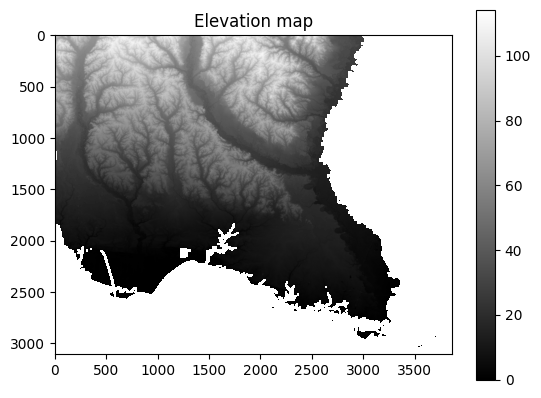

In [ ]:
elevation = load_array_from_npy("elevation")

masked_elevation = np.ma.array(elevation, mask = shape_mask)
plt.imshow(masked_elevation, cmap='gray')
plt.title('Elevation map')
plt.colorbar()
plt.show()

### Curvature

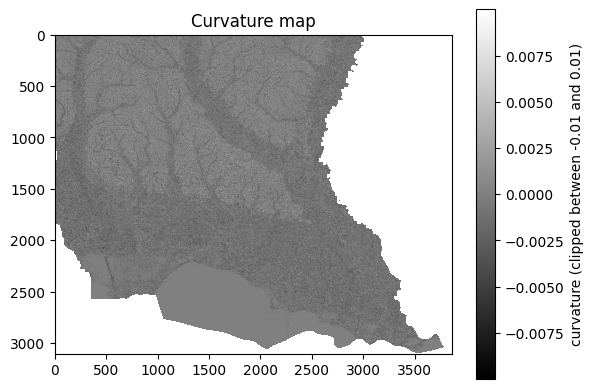

In [ ]:
curvature = load_array_from_npy("curvature")
bin_curvature = load_array_from_npy("bin_curvature")

bound = 1e-2
masked_curvature = np.ma.array(curvature.clip(-bound,bound), mask = shape_mask)
plt.imshow(masked_curvature, cmap='gray')
plt.title('Curvature map')
plt.colorbar(label=f'curvature (clipped between -{bound} and {bound})')
plt.show()

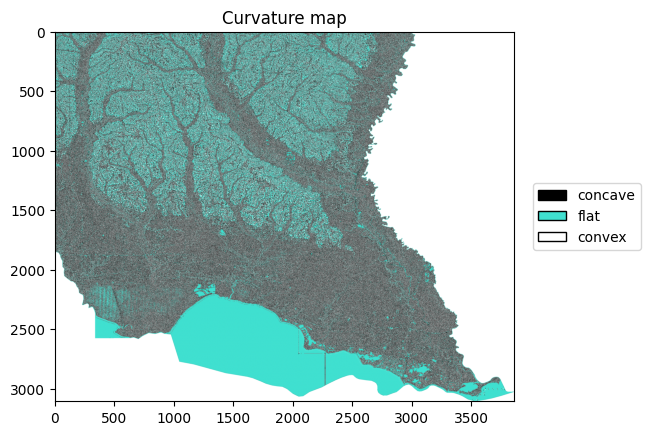

In [ ]:

color_list = ['black','turquoise','white']

cmap = dict(zip([-1,0,1], [to_rgba(c, alpha=1) for c in color_list]))

labels = {-1:'concave',0:'flat',1:'convex'}
arrayShow = np.array([[cmap[i] for i in j] for j in bin_curvature])

# set alpha value to zero when outside the region of interest
arrayShow[:,:,3] = ~shape_mask

patches =[mpatches.Patch(facecolor=cmap[i],
                         label=labels[i],
                         edgecolor='black') for i in cmap]

plt.imshow(arrayShow)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left",  #loc=3,
           handles=patches, borderaxespad=0.)
plt.title('Curvature map')
plt.show()

### Aspect

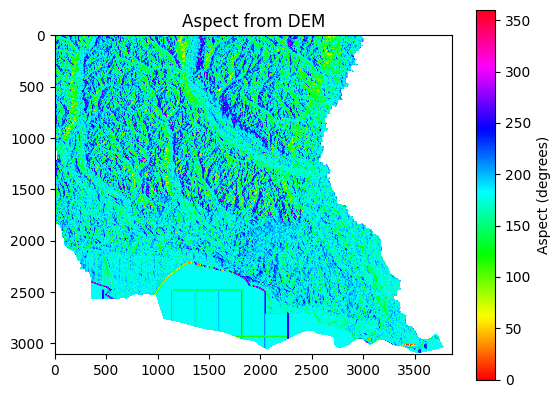

In [ ]:
aspect_deg = load_array_from_npy("aspect_deg")

masked_aspect_deg = np.ma.array(aspect_deg, mask = shape_mask)
plt.imshow(masked_aspect_deg, cmap='hsv', vmin=0, vmax=360)
plt.colorbar(label='Aspect (degrees)')
plt.title('Aspect from DEM')
plt.show()

In [ ]:
bin_aspect = load_array_from_npy("bin_aspect")
aspect_flat = load_array_from_npy("aspect_flat")

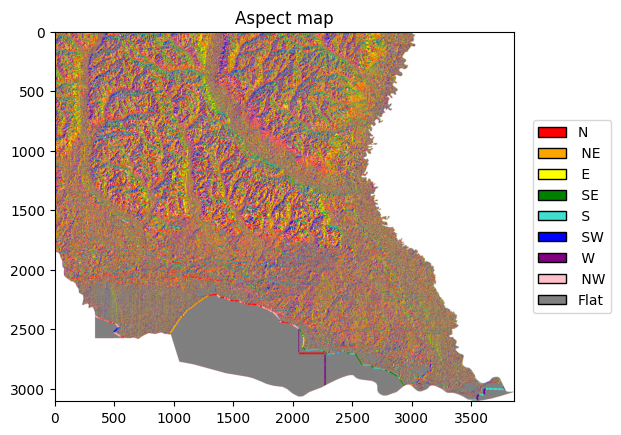

In [ ]:
color_list = ['red','orange','yellow','green',
             'turquoise','blue','purple','pink', 'gray']

cmap = dict(zip(range(9),[to_rgba(c,alpha=1) for c in color_list]))

labels = dict(zip(range(9), ['N',' NE',' E',' SE',' S',' SW',' W',' NW', 'Flat']))

bin_aspect[aspect_flat] = 8
arrayShow = np.array([[cmap[i] for i in j] for j in bin_aspect])

# set alpha value to zero when outside the region of interest
arrayShow[:,:,3] = ~shape_mask

patches =[mpatches.Patch(facecolor=cmap[i],
                         label=labels[i],
                         edgecolor='black') for i in cmap]

plt.imshow(arrayShow)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left",
           handles=patches, borderaxespad=0.)
plt.title('Aspect map')
plt.show()

### Slope angle

# New Section

In [ ]:
slope_angle = load_array_from_npy("slope_angle")

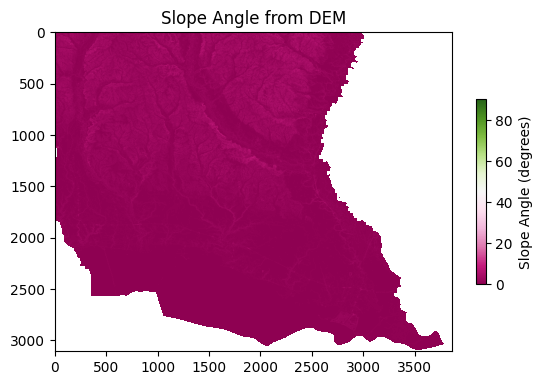

In [ ]:
# Visualize the slope angle data

masked_slope_angle = np.ma.array(slope_angle, mask = shape_mask)
plt.imshow(masked_slope_angle, cmap='PiYG')
plt.colorbar(label='Slope Angle (degrees)', shrink=0.5)
plt.title('Slope Angle from DEM')
plt.show()

## Flood inventory

In [ ]:
flood_path = "/content/drive/MyDrive/PROJECT ML/data"

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
df = pd.read_csv(os.path.join(flood_path, "preprocessed/flood_coords.csv"))
df

,latitude,longitude
0,30.614470,-90.240760
1,30.936490,-90.500570
2,30.875300,-90.500470
3,30.876640,-90.492230
4,30.874874,-90.500008
...,...,...
1020,30.092650,-91.980550
1021,30.092140,-91.987690
1022,30.092640,-91.980500
1023,30.181490,-92.047880


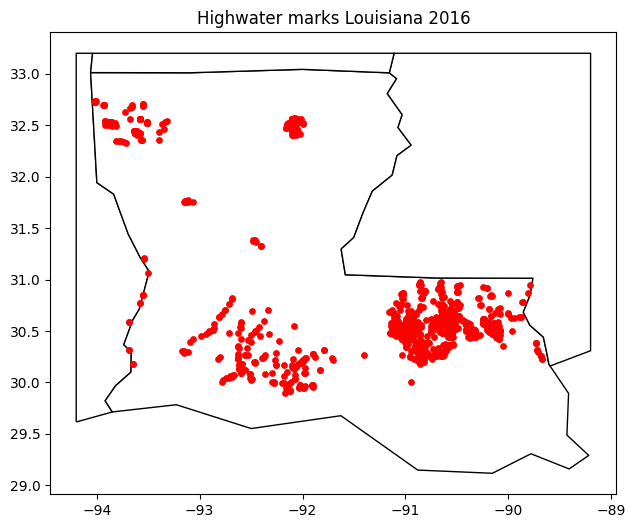

In [ ]:
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
fn = os.path.join(flood_path,'ne_110m_admin_1_states_provinces')
world = gpd.read_file(fn)
ax = world.clip([-94.2, 25, -89.2, 33.2]).plot(color="white", edgecolor="black",figsize=(10, 6))
gdf.plot(ax=ax, marker='o', color='red', markersize=15)
plt.title("Highwater marks Louisiana 2016")
plt.show()

In [ ]:
input_dem_path = os.path.join(input_path, "USGS_1_n31w091_20231101.tif")

with rasterio.open(input_dem_path) as src:
    # Read the DEM data as a NumPy array
    dem_data = src.read(1)

    print(src.bounds)


BoundingBox(left=-90.56750000003481, bottom=30.138888889177547, right=-89.49472222222143, top=31.001666666983965)


In [ ]:
lat, lon = 38.936490, -90.500570
lat, lon = 30.181490, -92.047880
src.index(lon, lat)

(2952, -5330)

In [ ]:
src.shape

(3106, 3862)

In [ ]:
flood_idx = []
for x in df.iloc:
    lat = x['latitude']
    lon = x['longitude']

    idx = src.index(lon, lat)
    if 0 <= idx[0] < src.shape[0] and \
        0 <= idx[1] < src.shape[1]:

        if not shape_mask[idx]:
            flood_idx.append((idx[0], idx[1]))

In [ ]:
print("Flood events in the inventory:",len(flood_idx))

Flood events in the inventory: 252


In [ ]:
df = pd.DataFrame(flood_idx)
df.to_csv(os.path.join(output_path, "flood_idx.csv"), index=False)
df

,0,1
0,1393,1176
1,234,240
2,454,241
3,450,270
4,456,242
...,...,...
247,1914,1619
248,1963,1640
249,1961,1634
250,1821,1434


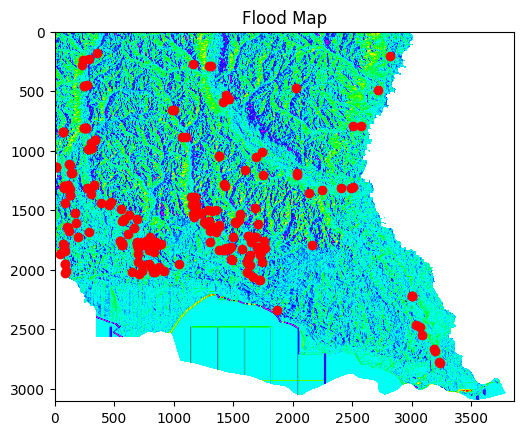

In [ ]:
aspect_deg = load_array_from_npy("aspect_deg")

masked_aspect_deg = np.ma.array(aspect_deg, mask = shape_mask)
plt.imshow(masked_aspect_deg, cmap='hsv', vmin=0, vmax=360)

for idx in flood_idx:
    plt.scatter(idx[1], idx[0], c='red')
plt.title('Flood Map')
plt.show()